# Imports

In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.6 MB/s 
     |████████████████████████████████| 6.5 MB 35.3 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 895 kB 33.9 MB/s 
     |████████████████████████████████| 596 kB 10.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import json
import os
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn import functional as F

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import AdamW,  get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load dataset

In [5]:
import pandas as pd 

In [6]:
data = pd.read_csv('/content/drive/My Drive/NLP_humor/jokes_dataset_MAIN_PREPROC.csv', 
                 sep=',', 
                 encoding='utf-8')

In [7]:
data.head()

,id,joke,rank
0,5tz52q,I hate how you cannot even say black paint any...,1
1,5tz4dd,What is the difference between a Jew in Nazi G...,0
2,5tz319,I recently went to America..... ...and being t...,0
3,5tz2wj,"Brian raises his hand and says, ""He is in Heav...",1
4,5tz1pc,You hear about the University book store worke...,0


In [8]:
data['Text_length'] = data.joke.str.split().str.len()

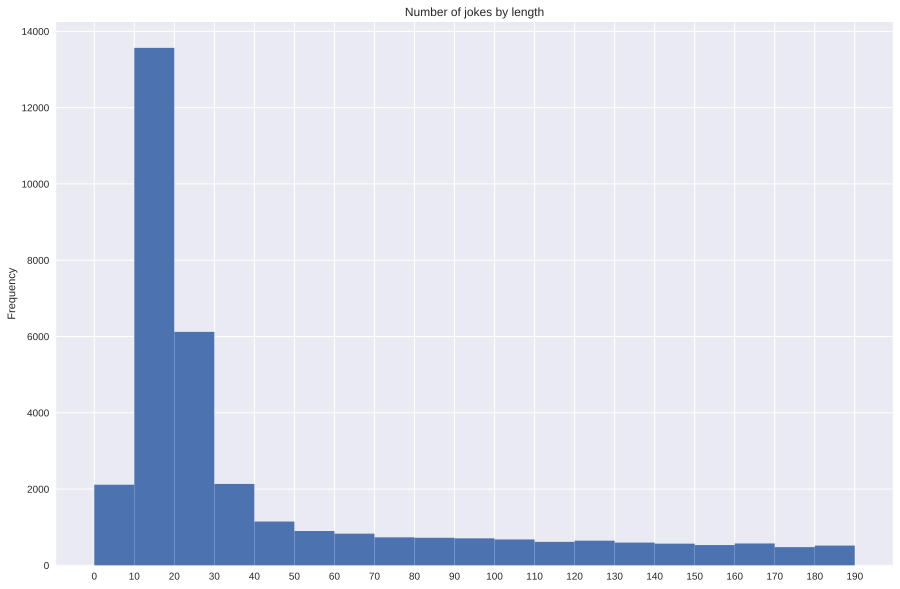

In [9]:
data[(data['rank'] == 4)]['Text_length'].plot(kind='hist', bins=range(0, 200, 10), xticks=range(0, 200,10), figsize=(15, 10), title='Number of jokes by length')
plt.show()

In [10]:
data[(data['rank'] == 4)]['Text_length'].mean()

70.74664508380764

In [11]:
df = data[(data['rank'] == 4) & (data['Text_length'] >= 8) & (data['Text_length'] <=70)]

In [12]:
df.dropna(inplace=True)

In [13]:
df.isna().sum()

id             0
joke           0
rank           0
Text_length    0
dtype: int64

In [14]:
# df.to_json(r'/content/drive/My Drive/NLP_humor/jokes_dataset_PREPROC.json')

# Load GPT2 Tokenizer from huggingface's transformers

In [15]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

### Limit the maximum token length because of RAM limitations.

In [16]:
joke_tokens = pd.DataFrame(df[['joke']].copy())
joke_tokens["len_tokens"] = joke_tokens.applymap(lambda x: len(tokenizer.encode(x)))
joke_tokens = joke_tokens.sort_values("len_tokens", ascending=False)
joke_tokens

,joke,len_tokens
82005,An elderly woman walks into a sex shop. She sl...,174
184005,DICTIONARY FOR DECODING WOMEN'S PERSONAL ADS. ...,159
131672,"shades of grey. #, #, #, #bbb, #ccc, #eee, #,...",150
121900,Are you ready kids? AYE AYE CAPTAIN! I cannot ...,134
47866,"Reading it one time might be not enough.. -""He...",132
...,...,...
175546,Nothing beats a beautiful woman.. Except Chris...,9
148176,I know someone who talks like an owl.,9
175339,Russian nesting dolls are so full of themselves..,9
153599,I cannot stand being in a wheelchair.. ...,9


In [17]:
jokes = joke_tokens.joke[joke_tokens.len_tokens <= 100]
jokes.shape

(26217,)

In [18]:
max_flavour = max([len(tokenizer.encode(joke)) for joke in jokes])

print(f'The longest flavour text is {max_flavour} tokens long.')

The longest flavour text is 100 tokens long.


### Create PyTorch Data Loaders

In [19]:
# reproducibility
def seed_everything(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [20]:
bs = 32 # batchsize

In [21]:


class JokeDataset(Dataset):
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_flavour):
        self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            """
            This loop will iterate through each entry in the flavour text corpus.
            For each bit of text it will prepend it with the start of text token,
            then append the end of text token and pad to the maximum length with the 
            pad token. 
            """

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                     truncation=True, 
                                     max_length=max_length, 
                                     padding="max_length")

            """
            Each iteration then appends either the encoded tensor to a list,
            or the attention mask for that encoding to a list. The attention mask is
            a binary list of 1's or 0's which determine whether the langauge model
            should take that token into consideration or not. 
            """
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import random_split
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

In [23]:
dataset = JokeDataset(jokes, tokenizer, max_length=max_flavour)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 23595 samples for training, and 2622 samples for validation testing'

In [24]:
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = bs 
        )

### Load pretrained GPT2 from huggingface

In [25]:
# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

### Fine-tune GPT2

In [26]:
# This step is optional but will enable reproducible runs.
seed_val = 42
seed_everything(seed_val)

In [27]:
epochs = 4
warmup_steps = 1e2
sample_every = 100

In [28]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, 
# and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

In [29]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [30]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 738. Loss:1.264219045639038. Time:0:02:32
Example output:  bipartisanHoney Booey, so I can take a vacation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 738. Loss:0.9807031750679016. Time:0:05:05
Example output:  increasingA man walks into a bar and announces "I am going to be your bartender." The bar owner immediately asks, "Hey, would you like a glass of wine or two?" He is quite proud of himself. "You want a glass of wine?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 738. Loss:0.9764599800109863. Time:0:07:40
Example output: dayWhy did the cannibal go blind?. He is blind, and cannot use the lid.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 738. Loss:1.2725719213485718. Time:0:10:13
Example output:  HangI was asked why I was so ugly. To which I replied: "Because I have never had my chin cut off"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 738. Loss:0.8628221154212952. Time:0:12:46
Example output:  foodsI used to joke with some girls that if I had two glasses of wine I might have  beers. But after one glass I think I would do it again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 738. Loss:0.8511626124382019. Time:0:15:19
Example output:  trailWhy did the farmer bring back  yolks?. They were both good.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 738. Loss:1.0425381660461426. Time:0:17:51
Example output: intendThe only thing I hate to see in porn. A woman on the floor masturbating.......a guy on the ceiling masturbating.
Average Training Loss: 1.3265096993465735. Epoch time: 0:18:48
Validation loss: 0.8720707122872515. Validation Time: 0:00:41
Beginning epoch 2 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 738. Loss:1.0549359321594238. Time:0:02:33
Example output:  surroundWhat do you call a fat woman who has no hands?. Bitter, daffy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 738. Loss:0.8939366936683655. Time:0:05:06
Example output:  reflexI like my women how I like my coffee.... Coffee and I will have a ball


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 738. Loss:0.8036253452301025. Time:0:07:38
Example output:  displayI once saw a girl at the bus stop.... and she had a really nice tits. But the bus stopped at our stop because I was caught flat-chewing our way to the toilets.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 738. Loss:0.7588325142860413. Time:0:10:11
Example output:  pastorSo I got my new dog to stay at my house. Now I just take him for walks.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 738. Loss:0.635430634021759. Time:0:12:43
Example output:  illicitI went to a psychiatrist today and asked him to prescribe me some Viagra.. He replied that he would not. I said "no, sir".


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 738. Loss:0.7006784081459045. Time:0:15:15
Example output:  LiberationHave you heard about the Mexican train?. It was so fast!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 738. Loss:0.7620096206665039. Time:0:17:47
Example output:  NamHow do you get your girlfriend to take a Viagra?. With a glass of Windex.
Average Training Loss: 0.8036742408262681. Epoch time: 0:18:43
Validation loss: 0.8227702924391118. Validation Time: 0:00:41
Beginning epoch 3 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 738. Loss:0.5912691950798035. Time:0:02:32
Example output: IONI was sitting at the bar last night and my wife turned to me and said, "I have something special you can drink with me when you are with us." She turned to me and said, "What? Are you kidding me?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 738. Loss:0.7696273326873779. Time:0:05:05
Example output:  glimpseMy dad wants to change his name to a sex position.. I told him I did not want to be called someone else's dad.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 738. Loss:0.642697274684906. Time:0:07:37
Example output:  LaureWhat do you call it when two whales get married?. A threesome.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 738. Loss:0.7308531999588013. Time:0:10:09
Example output: ismI asked my wife if she ever had sex before.... She said "That is because you are so fucking gorgeous."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 738. Loss:0.7122347950935364. Time:0:12:41
Example output: ounDid you hear about the time that Stephen Hawking was caught masturbating?. The police caught him after he tried to write them off.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 738. Loss:0.6477303504943848. Time:0:15:13
Example output:  electionWhat is the most popular position for a politician to move?. To the right.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 738. Loss:0.7222983837127686. Time:0:17:45
Example output:  crazyI got really angry when I got arrested for possession of illegal drugs in Arkansas.... I could not concentrate.
Average Training Loss: 0.6896572659009195. Epoch time: 0:18:42
Validation loss: 0.80868187910173. Validation Time: 0:00:41
Beginning epoch 4 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 738. Loss:0.5423797965049744. Time:0:02:32
Example output:  benchWhat is the difference between a joke and  dicks?. Your mom cannot take a joke.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 738. Loss:0.6130194067955017. Time:0:05:05
Example output:  incorporatedA man wakes up with  cups of coffee in his hand and a quarter in the other. The doctor takes one cup of coffee and puts another cup under his ear. "So you are thinking you should take two cups of coffee in the morning and one cup of coke in the evening?" "No", the man says, "I am not sure what you are thinking."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 738. Loss:0.6112486124038696. Time:0:07:38
Example output: PeterWhat do you call a black guy walking into a bar?. A tourist


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 738. Loss:0.5564193725585938. Time:0:10:10
Example output: uringWhat did the cannibal do after his wife dumped him?. Wiped his ass


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 738. Loss:0.6074026823043823. Time:0:12:42
Example output:  reproductiveWhat do you call two gay deer in a gay deer pond?. Fucks damn kids.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 738. Loss:0.65481036901474. Time:0:15:14
Example output:  zoneWhat is black and does not work?. Decaf Coffee


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 738. Loss:0.6492449641227722. Time:0:17:46
Example output:  commitsHave you heard about the new antidepressant, Wellbuterol?. They are making their first announcement.
Average Training Loss: 0.6066056795236541. Epoch time: 0:18:43
Validation loss: 0.8166155255422359. Validation Time: 0:00:41
Total training took 1:17:41


In [ ]:
# What is black and does not work?. Decaf Coffee

### Investigate Losses

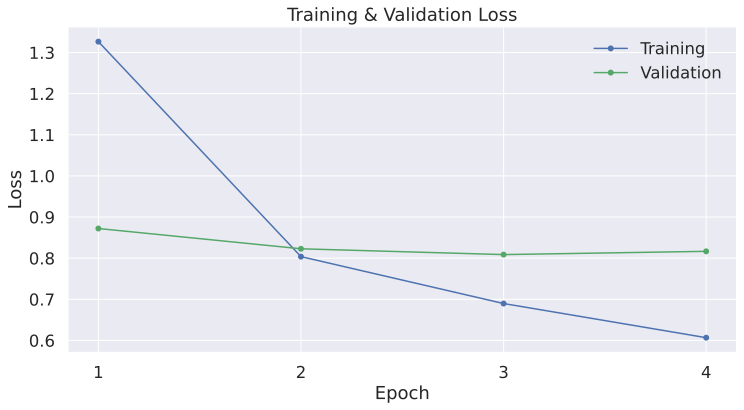

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Generate Jokes

In [32]:
model.eval()
seed_everything(42)

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=25 # if set then no sample?
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Why did the tomato blush?. Because he heard the tomato was home.


1: How do you make your girlfriend scream when she is in the car?. Pull her over.


2: When I asked my father what he is doing during his vacation..... He said, 'Leather armor and a hat.'


3: A blonde chick with a lazy eye tells a blonde girl. "How can I get to you?. This is the ugliest post I have ever come across!" The blonde replies. "You mean you know how to post this?" "No, but you do not get to post it anywhere. It is called my retarded."


4: I used to be a pretty bad cook,. but I now just like my vegetables.


5: A man tried to sell me a boob job the other day... I told him I want a boob job, but he told me "You are a piece of shit."


6: A guy goes to the doctor with a very unusual rash on his dick. He complains that it is getting worse and worse, the doctor tells him "it is nothing, he is just trying to get up the nerve". The guy replies "well, you are going to need to stop masturbating".


7: I am beginni

# Save Model

In [33]:
import os

output_dir = '/content/drive/My Drive/NLP_humor/models/'

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/My Drive/NLP_humor/models/tokenizer_config.json',
 '/content/drive/My Drive/NLP_humor/models/special_tokens_map.json',
 '/content/drive/My Drive/NLP_humor/models/vocab.json',
 '/content/drive/My Drive/NLP_humor/models/merges.txt',
 '/content/drive/My Drive/NLP_humor/models/added_tokens.json')